In [1]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from imblearn.datasets import fetch_datasets

from imblearn.under_sampling import (
    RandomUnderSampler,
    CondensedNearestNeighbour,
    TomekLinks,
    OneSidedSelection,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN,
    NeighbourhoodCleaningRule,
    NearMiss,
    InstanceHardnessThreshold
)

In [2]:
undersampler_dict = {

    'random': RandomUnderSampler(
        sampling_strategy='auto',
        random_state=0,
        replacement=False),

    'cnn': CondensedNearestNeighbour(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=4),

    'tomek': TomekLinks(
        sampling_strategy='auto',
        n_jobs=4),

    'oss': OneSidedSelection(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=4),

    'enn': EditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4),

    'renn': RepeatedEditedNearestNeighbours(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4,
        max_iter=100),

    'allknn': AllKNN(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4),

    'ncr': NeighbourhoodCleaningRule(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=4,
        threshold_cleaning=0.5),

    'nm1': NearMiss(
        sampling_strategy='auto',
        version=1,
        n_neighbors=3,
        n_jobs=4),

    'nm2': NearMiss(
        sampling_strategy='auto',
        version=2,
        n_neighbors=3,
        n_jobs=4),

    'iht': InstanceHardnessThreshold(
        estimator=LogisticRegression(random_state=0),
        sampling_strategy='auto',
        random_state=0,
        n_jobs=4,
        cv=3)
}

In [3]:
# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(
        n_estimators=100, random_state=39, max_depth=3, n_jobs=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = rf.predict_proba(X_test)
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

    return roc_auc_score(y_test, pred[:, 1])

In [4]:
datasets_ls = pd.read_excel("dados2.xlsx")
df = datasets_ls

In [5]:
results_dict = {}
shapes_dict = {}

for dataset_label, dataset in {"df1":df}.items():
    
    results_dict[dataset_label] = {}
    shapes_dict[dataset_label] = {}
    
    X = dataset.drop(['Flag_apo_anul', 'NIF'], axis=1)
    y = dataset['Flag_apo_anul']


    X_train, X_test, y_train, y_test = train_test_split(
    X,  # drop the target
    y,  # just the target
    test_size=0.3,
    random_state=0)
    
    # as many undersampling techniques use KNN
    # we set variables in the same scale
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
        
    roc = run_randomForests(X_train, X_test, y_train, y_test)
    
    # store results
    results_dict[dataset_label]['full_data'] = roc
    shapes_dict[dataset_label]['full_data'] = len(X_train)
    
    print()
    
    for undersampler in undersampler_dict.keys():
        
        print(undersampler)
        
        # resample
        X_resampled, y_resampled = undersampler_dict[undersampler].fit_resample(X_train, y_train)
        
        # evaluate performance
        roc = run_randomForests(X_resampled, X_test, y_resampled, y_test)
        
        #store results
        results_dict[dataset_label][undersampler] = roc
        shapes_dict[dataset_label][undersampler] = len(X_resampled)
        print()
        
    print()
        

Train set
Random Forests roc-auc: 0.9221326836581708
Test set
Random Forests roc-auc: 0.7619047619047619

random
Train set
Random Forests roc-auc: 0.986328125
Test set
Random Forests roc-auc: 0.6315192743764172

cnn
Train set
Random Forests roc-auc: 0.9158909574468085
Test set
Random Forests roc-auc: 0.6819727891156462

tomek
Train set
Random Forests roc-auc: 0.9389247720364742
Test set
Random Forests roc-auc: 0.6995464852607709

oss
Train set
Random Forests roc-auc: 0.9302067233384853
Test set
Random Forests roc-auc: 0.6944444444444444

enn
Train set
Random Forests roc-auc: 0.9434121621621622
Test set
Random Forests roc-auc: 0.7318594104308389

renn
Train set
Random Forests roc-auc: 0.9348488267148015
Test set
Random Forests roc-auc: 0.7403628117913832

allknn
Train set
Random Forests roc-auc: 0.9384303852889668
Test set
Random Forests roc-auc: 0.7244897959183674

ncr
Train set
Random Forests roc-auc: 0.9323630136986302
Test set
Random Forests roc-auc: 0.7613378684807257

nm1
Train se

In [6]:
#Compare the full-Dataset (without under-sampling) with the different methods of under-sampling

lb = pd.Series(results_dict[dataset_label]).sort_values(ascending=False)
lb

full_data    0.761905
ncr          0.761338
iht          0.761338
renn         0.740363
enn          0.731859
allknn       0.724490
tomek        0.699546
oss          0.694444
cnn          0.681973
random       0.631519
nm2          0.412132
nm1          0.400794
dtype: float64

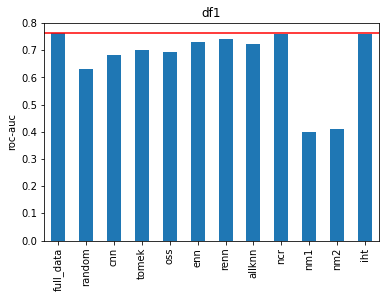

In [7]:
#Compare with a barplot the full-Dataset (without under-sampling) with the different methods of under-sampling

pd.Series(results_dict[dataset_label]).plot.bar()
plt.title(dataset_label)
plt.ylabel('roc-auc')
plt.axhline(results_dict[dataset_label]['full_data'], color='r')
plt.show()